In [4]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
os.environ['FOUNDATION_SAVE_DIR'] = r'D:\completed'
os.environ['FOUNDATION_DATA_DIR'] = r'D:\local_data'
# %load_ext autoreload
# %autoreload 2
# %pdb
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np
import pickle

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib import cm
# mpl.rc('image', cmap='gray')

# import gpumap
# import umap, shap
# import umap.plot
from adjustText import adjust_text

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from sklearn.decomposition import PCA
import sklearn.datasets

# import gpumap


import visualizations as viz_util
import project as proj
# import pointnets as ptn

%matplotlib notebook

np.set_printoptions(linewidth=120)

In [5]:
%matplotlib notebook

In [6]:

# SMALL_SIZE = 14
# MEDIUM_SIZE = 16
# BIGGER_SIZE = 18

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
root = os.environ['FOUNDATION_SAVE_DIR']


In [8]:
def organize(raw, runs=None, **common):
    raw = raw.split('\n')
    if runs is None:
        runs = util.Table()
    for line in raw:
        n,t,r = line.split('\t')
        runs.new(name=n, arch=t, rname=r, **common)
    return runs

def save_fig(name):
    plt.savefig(f'figures/{name}.png')
    plt.savefig(f'figures/{name}.pdf')
    print(name, 'saved')
    
def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    
fixed_name_codes = {
    '12 Branch': 'K12',
    '6 Branch': 'K6',
    '4 Branch': 'K4',
    
    '12 Head': 'H12',
    '6 Head': 'H6',
    '4 Head': 'H4',
    
    '12 LVAE': 'L12',
    '6 LVAE': 'L6',
    '4 LVAE': 'L4',
}
fixed_names = {
    '12 Branch': '12-SAE',
    '6 Branch': '6-SAE',
    '4 Branch': '4-SAE',
    
    '12 Head': '12-ASAE',
    '6 Head': '6-ASAE',
    '4 Head': '4-ASAE',
    
    '12 LVAE': '12-VLAE',
    '6 LVAE': '6-VLAE',
    '4 LVAE': '4-VLAE',
}

def fix_names(run):
    
    if run.name in fixed_name_codes:
        run.code = fixed_name_codes[run.name]
    else:
        run.code = run.name
        
    if run.name in fixed_names:
        run.name = fixed_names[run.name]

def encode(model, X):
    with torch.no_grad():
        q = model.encode(X.cuda())
    if isinstance(q, distrib.Distribution):
        q = q.mean
    return q.cpu()

In [9]:
info = util.tdict()

In [10]:



info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {
    'Branch':'C0', 
          'Baseline':'C1', 
          'Conv':'C2', 
          'Attention':'C3',
        'Ladder': 'C4',
         }
info.tnames = {'Branch':'Structural', 'Baseline':'Baseline', 'Conv':'Simple', 'Attention':'Attention', 'Ladder': 'Ladder'}

preset_figure_info(info)
print(info)

t{results_name, small_font_size, medium_font_size, large_font_size, colors, tnames}


In [11]:
model_names = [
    ('AE', 'Conv'),
    ('VAE', 'Conv'),
    ('4VAE', 'Conv'),
    ('16VAE', 'Conv'),
    ('WAE', 'Conv'),
    ('12 Branch', 'Branch'),
    ('6 Branch', 'Branch'),
    ('4 Branch', 'Branch'),
    ('12 Head', 'Attention'),
    ('6 Head', 'Attention'),
    ('4 Head', 'Attention'),
    ('4 LVAE', 'Ladder'),
    ('6 LVAE', 'Ladder'),
    ('12 LVAE', 'Ladder'),
    ('AE', 'Baseline'),
    ('VAE', 'Baseline'),
    ('4VAE', 'Baseline'),
    ('16VAE', 'Baseline'),
    ('WAE', 'Baseline'),
]
len(model_names)

19

In [12]:
raw = '''AE	Conv	3ds-ae-conv_0002-6337051-00_200508-232722
AE-L2	Conv	3ds-ae-b1-conv_0002-6337051-01_200508-232718
VAE	Conv	3ds-vae-b1-conv_0002-6337051-03_200508-232715
2VAE	Conv	3ds-vae-b2-conv_0002-6337051-04_200508-232711
4VAE	Conv	3ds-vae-b4-conv_0002-6337051-05_200508-232713
8VAE	Conv	3ds-vae-b8-conv_0002-6337051-06_200508-232748
16VAE	Conv	3ds-vae-b16-conv_0002-6337051-07_200508-232723
32VAE	Conv	3ds-vae-b32-conv_0002-6337051-08_200508-232717
WAE	Conv	3ds-wae-conv_0002-6337051-02_200508-232718
12 Branch	Branch	3ds-ae-12b1-conv_0005-6337809-01_200509-120419
6 Branch	Branch	3ds-ae-6b2-conv_0034-6373616-01_200518-163704
4 Branch	Branch	3ds-ae-4b3-conv_0034-6373616-00_200518-163709
12 Head	Attention	3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612
6 Head	Attention	3ds-ae-12b1-6h1k32v32_0001-6337050-08_200508-232652
4 Head	Attention	3ds-ae-12b1-4h1k32v32_0001-6337050-07_200508-232614
12 LVAE	Ladder	3ds-vae-lddrev12_0042-6464006-07_200522-152910
12 Ladder-AE	Ladder	3ds-ae-lddrev12_0042-6464006-04_200522-152948
6 LVAE	Ladder	3ds-vae-lddrev6_0042-6464006-06_200522-152917
6 Ladder-AE	Ladder	3ds-ae-lddrev6_0042-6464006-03_200522-152912
4 LVAE	Ladder	3ds-vae-lddrev4_0042-6464006-05_200522-152911
4 Ladder-AE	Ladder	3ds-ae-lddrev4_0042-6464006-02_200522-152915
AE	Baseline	3ds-ae-dislib_0003-6337807-00_200509-120112
AE-L2	Baseline	3ds-ae-b1-dislib_0003-6337807-01_200509-120113
VAE	Baseline	3ds-vae-b1-dislib_0003-6337807-03_200509-120115
2VAE	Baseline	3ds-vae-b2-dislib_0003-6337807-04_200509-120115
4VAE	Baseline	3ds-vae-b4-dislib_0003-6337807-05_200509-120125
8VAE	Baseline	3ds-vae-b8-dislib_0003-6337807-06_200509-120109
16VAE	Baseline	3ds-vae-b16-dislib_0003-6337807-07_200509-120113
32VAE	Baseline	3ds-vae-b32-dislib_0003-6337807-08_200509-120119
WAE	Baseline	3ds-wae-dislib_0003-6337807-02_200509-120136'''



info.ds = '3ds'
info.fsize = (6,4)
info.title = '3D-Shapes'

info.bidx = 9
info.bidx = 2
# info.highlight = [-1,0,-1,1,2,-1,3,3,4,4,5,5,]

In [657]:
raw = '''AE	Conv	mpi3d-ae-conv_0011-6341579-00_200511-035009
AE-L2	Conv	mpi3d-ae-b1-conv_0011-6341579-01_200511-035004
VAE	Conv	mpi3d-vae-b1-conv_0011-6341579-03_200511-035007
2VAE	Conv	mpi3d-vae-b2-conv_0011-6341579-04_200511-035008
4VAE	Conv	mpi3d-vae-b4-conv_0011-6341579-05_200511-035016
8VAE	Conv	mpi3d-vae-b8-conv_0011-6341579-06_200511-035007
16VAE	Conv	mpi3d-vae-b16-conv_0011-6341579-07_200511-035003
32VAE	Conv	
WAE	Conv	mpi3d-wae-conv_0011-6341579-02_200511-035010
12 Branch	Branch	mpi3d-ae-12b1-conv_0011-6341579-09_200511-035023
6 Branch	Branch	mpi3d-ae-toy-6b2_0056-6468034-01_200525-033418
4 Branch	Branch	mpi3d-ae-toy-4b3-conv_0071-6472326-00_200526-191939
12 Head	Attention	mpi3d-ae-12b1-12h1k32v32_0013-6343740-04_200512-014614
6 Head	Attention	mpi3d-ae-12b1-6h1k32v32_0013-6343740-08_200512-014603
4 Head	Attention	mpi3d-ae-12b1-4h1k32v32_0013-6343740-07_200512-014605
12 LVAE	Ladder	mpi3d-vae-lddrev12_0042-6464006-13_200522-152922
12 Ladder-AE	Ladder	mpi3d-ae-lddrev12_0042-6464006-10_200522-152920
6 LVAE	Ladder	mpi3d-vae-toy-lddrev6_0071-6472326-01_200526-191942
6 Ladder-AE	Ladder	mpi3d-ae-lddrev6_0042-6464006-09_200522-152920
4 LVAE	Ladder	mpi3d-vae-lddrev4_0042-6464006-11_200522-152927
4 Ladder-AE	Ladder	mpi3d-ae-lddrev4_0042-6464006-08_200522-152926'''

if ('16VAE', 'Baseline') in model_names:
    model_names.remove(('16VAE', 'Baseline'))

info.ds = 'toy'
info.fsize = (6,4)
info.title= 'MPI3D Toy'
info.bidx = 13 #24
# info.highlight = [0,0,0,1,2,3,4,4,5,-1,6,5,] # toy
info.ridx = 2
info.baselines = {}


In [708]:
raw = '''AE	Conv	mpi3d-ae-conv_0012-6341580-00_200511-035101
AE-L2	Conv	mpi3d-ae-b1-conv_0012-6341580-01_200511-035039
VAE	Conv	mpi3d-vae-b1-conv_0012-6341580-03_200511-035054
2VAE	Conv	mpi3d-vae-b2-conv_0012-6341580-04_200511-035041
4VAE	Conv	mpi3d-vae-b4-conv_0012-6341580-05_200511-035040
8VAE	Conv	mpi3d-vae-b8-conv_0012-6341580-06_200511-035042
16VAE	Conv	mpi3d-vae-b16-conv_0012-6341580-07_200511-035036
32VAE	Conv	
WAE	Conv	mpi3d-wae-conv_0012-6341580-02_200511-035101
12 Branch	Branch	mpi3d-ae-12b1-conv_0012-6341580-09_200511-035033
6 Branch	Branch	mpi3d-ae-real-6b2_0056-6468034-03_200525-033420
4 Branch	Branch	mpi3d-ae-real-4b3_0056-6468034-02_200525-033422
12 Head	Attention	mpi3d-ae-12b1-12h1k32v32_0015-6346974-04_200513-020758
6 Head	Attention	mpi3d-ae-12b1-6h1k32v32_0015-6346974-08_200513-020756
4 Head	Attention	mpi3d-ae-12b1-4h1k32v32_0015-6346974-07_200513-020753
12 LVAE	Ladder	mpi3d-vae-real-lddrev12_0048-6464516-02_200522-212011
12 Ladder-AE	Ladder	mpi3d-ae-real-lddrev12-s2_0071-6472326-07_200526-191933
6 LVAE	Ladder	mpi3d-vae-real-lddrev6_0048-6464516-01_200522-212003
6 Ladder-AE	Ladder	mpi3d-ae-real-lddrev6_0071-6472326-03_200526-191932
4 LVAE	Ladder	mpi3d-vae-real-lddrev4_0048-6464516-00_200522-212001
4 Ladder-AE	Ladder	mpi3d-ae-real-lddrev4_0071-6472326-04_200526-191934'''

if ('16VAE', 'Conv') in model_names:
    model_names.remove(('16VAE', 'Conv'))

info.ds = 'real'
info.fsize = (6,4)
info.title= 'MPI3D Real'
info.bidx = 24 #48
info.bidx = 13
# info.highlight = [0,1,0,1,0,2,-1,3,4,5,5,-1]
info.ridx = 2
info.baselines = {}


In [13]:
runs = organize(raw, dataset=info.ds)
runs.filter_(lambda r: (r.name, r.arch) in model_names)
# runs.filter_(lambda r: r.arch == 'Attention')

runs.map(fix_names)
len(runs)

19

In [14]:
# runs[4].rname = '3ds-ae-12b1_0052-6286534-00_200429-030431'

In [15]:
def load_model(run):
    if 'model' not in run:
        A = trn.get_config()
        A.din = (3, 64, 64)
        A.dout = A.din

        model, = trn.load(run.rname, config=A, get_data=None, update_config=True) # for loading only the model
        run.model = model
    
def load_data(run):
    rname = run.rname
    if info.results_name not in run:
        full = torch.load(os.path.join(root, rname, f'{info.results_name}.pth.tar'))
        run[info.results_name] = full

In [16]:
runs.map(load_data, pbar=tqdm)
pass

In [17]:
run = runs[0]
run.rname

'3ds-ae-conv_0002-6337051-00_200508-232722'

In [18]:
print(run[info.results_name].keys())
print(run[info.results_name]['out'].keys())

dict_keys(['out', 'stats', 'stats_num', 'rec_fid_stats', 'rec_fid', 'hyb_fid_stats', 'hyb_fid'])
odict_keys(['original', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs'])


In [19]:
X = run[info.results_name]['out']['original']
X.shape

torch.Size([128, 3, 64, 64])

<IPython.core.display.Javascript object>


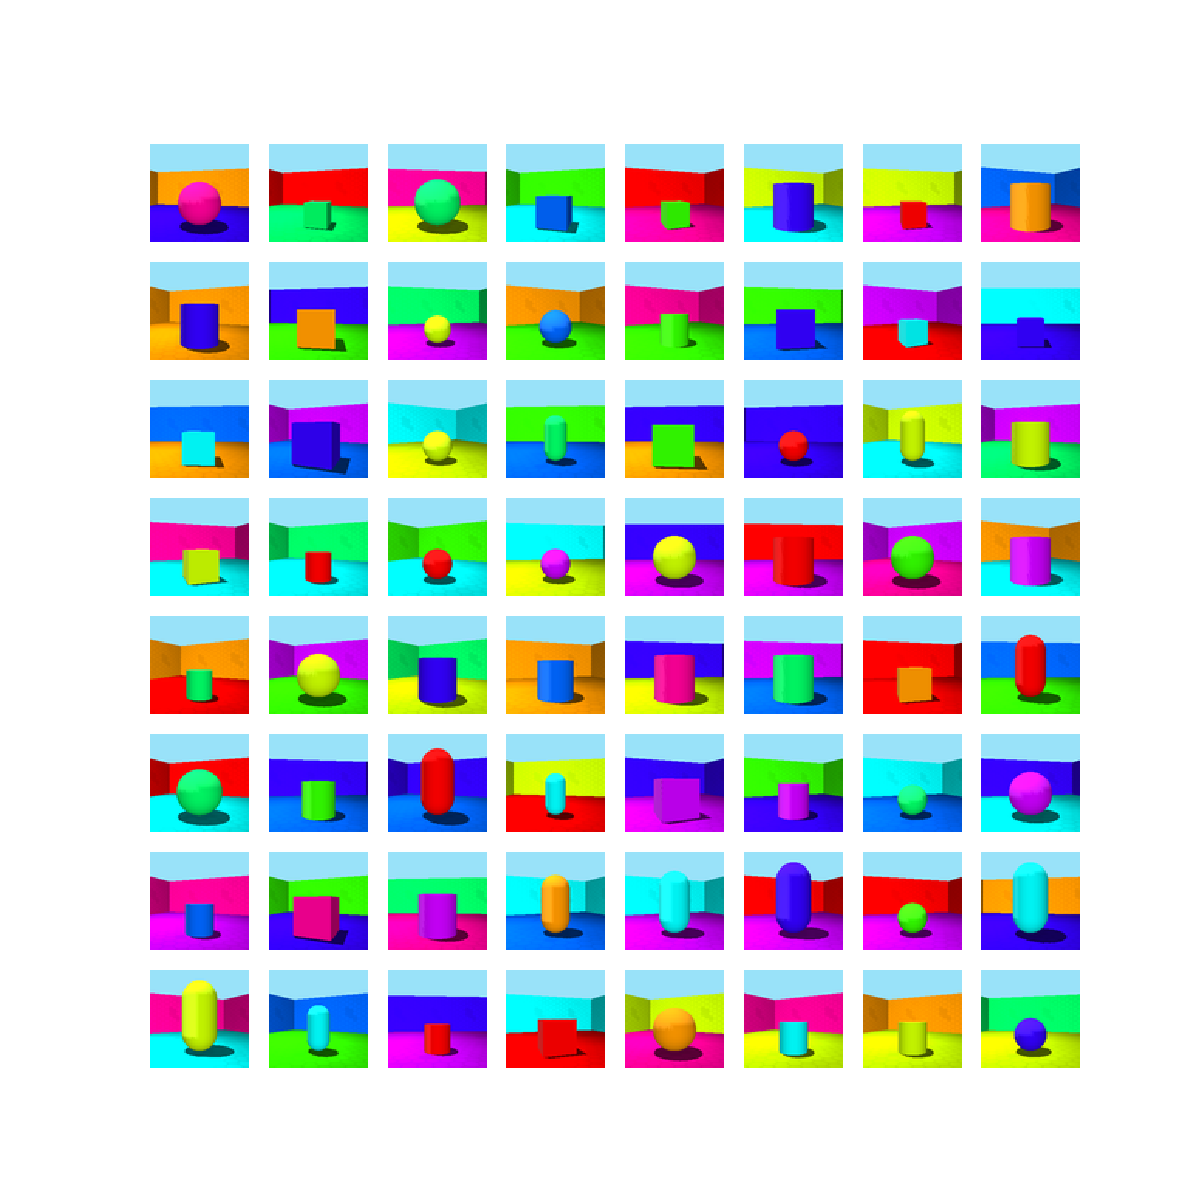

In [20]:
util.show_imgs(X[:64])
pass

In [488]:
# with torch.no_grad():
#     raw_Q = model.encode(X)
#     if isinstance(raw_Q, distrib.Distribution):
#         Q = raw_Q.mean
#     else:
#         Q = raw_Q
#     rec = model.decode(raw_Q)
# Q.shape, rec.shape

In [21]:
def _loss(r):
    r.loss = r[info.results_name]['stats']['rec_loss']['avg']
runs.map(_loss)
def _fid(r):
    r.fid = r[info.results_name]['rec_fid']
runs.map(_fid)
pass

In [22]:
l = list(runs.select('loss'))
lossrg = max(l)-min(l)
l = list(runs.select('fid'))
fidrg = max(l)-min(l)
lossrg,fidrg

(76.93798828125, 61.83429055997249)

<IPython.core.display.Javascript object>


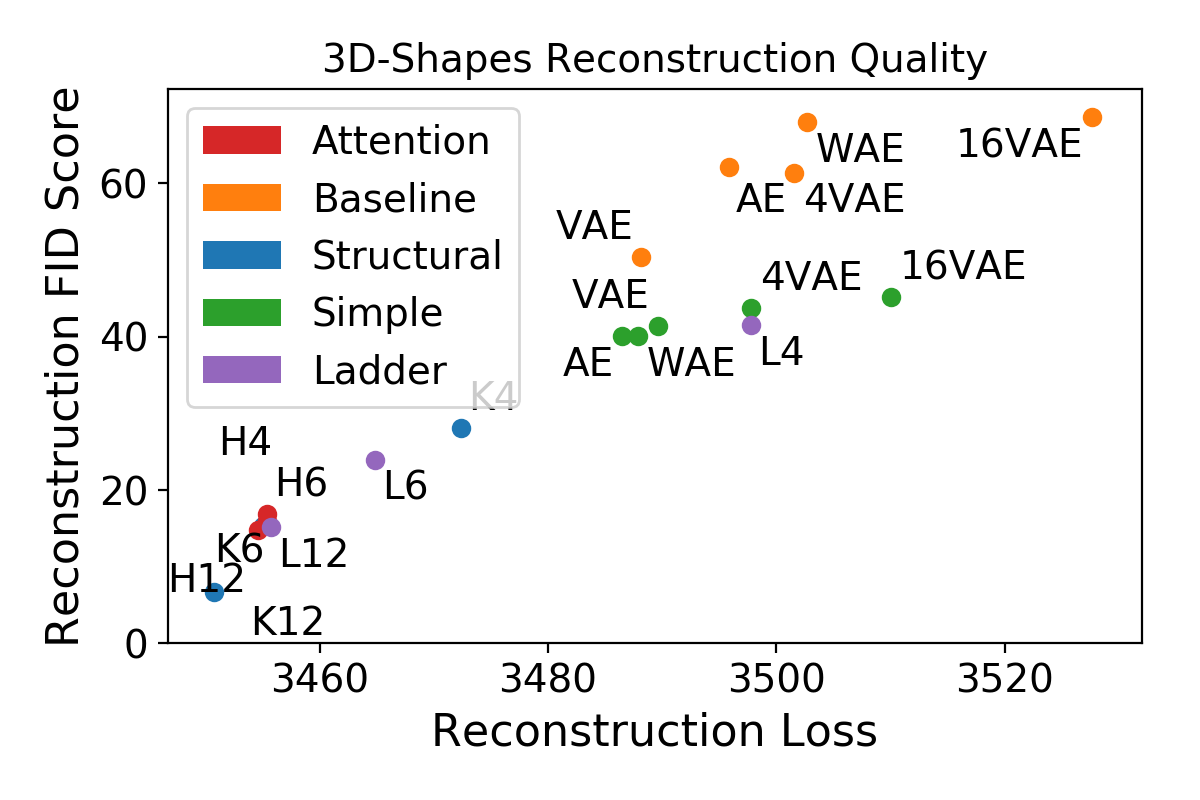

In [23]:
fig, ax = plt.subplots(figsize=info.fsize)
objs = []
texts = []
tps = set()
for r in runs:
    objs.append(plt.scatter(r.loss, r.fid, color=info.colors[r.arch]))
#     texts.append(plt.text(r.loss-(lossrg/10 if r.type == 'attn' else 0), r.fid, r.name))
    texts.append(plt.text(r.loss, r.fid, r.code, horizontalalignment='center',
      verticalalignment='center',))
    tps.add(r.arch)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))

legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in tps]
plt.legend(handles=legend_elements)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.xlim(left=6370)
plt.ylim(bottom=0)
plt.tight_layout()
adjust_text(texts, #force_text=(0.1,0.1)
            #force_text=(0.1,0.25),
            add_objects=objs,
           )
pass

In [779]:
# save_fig(f'{info.ds}_{info.results_name}_perf')

3ds_final_perf saved


In [24]:
def _fid(r):
    r.gen = r[info.results_name]['hyb_fid']
    if 'prior_fid' in r[info.results_name]:
        r.prior = r[info.results_name]['prior_fid']
runs.map(_fid)
pass

In [25]:
names, hybs, typs = zip(*runs.selects('name', 'fid', 'arch'))
pnames, priors, ptyps = zip(*runs.selects('name', 'prior', 'arch'))
names = np.array(names + pnames)
scores = np.array(hybs + priors)
typs = np.array(typs + ptyps)
tps = np.array(['hyb']*len(hybs) + ['prior']*len(priors))
order = np.argsort(scores)
names = names[order]
scores = scores[order]
typs = typs[order]
tps = tps[order]
eclrs = [('xx' if t == 'hyb' else 'oo') for t in tps]
clrs = [info.colors[t] for t in typs]
len(names), len(scores)

(30, 30)

<IPython.core.display.Javascript object>


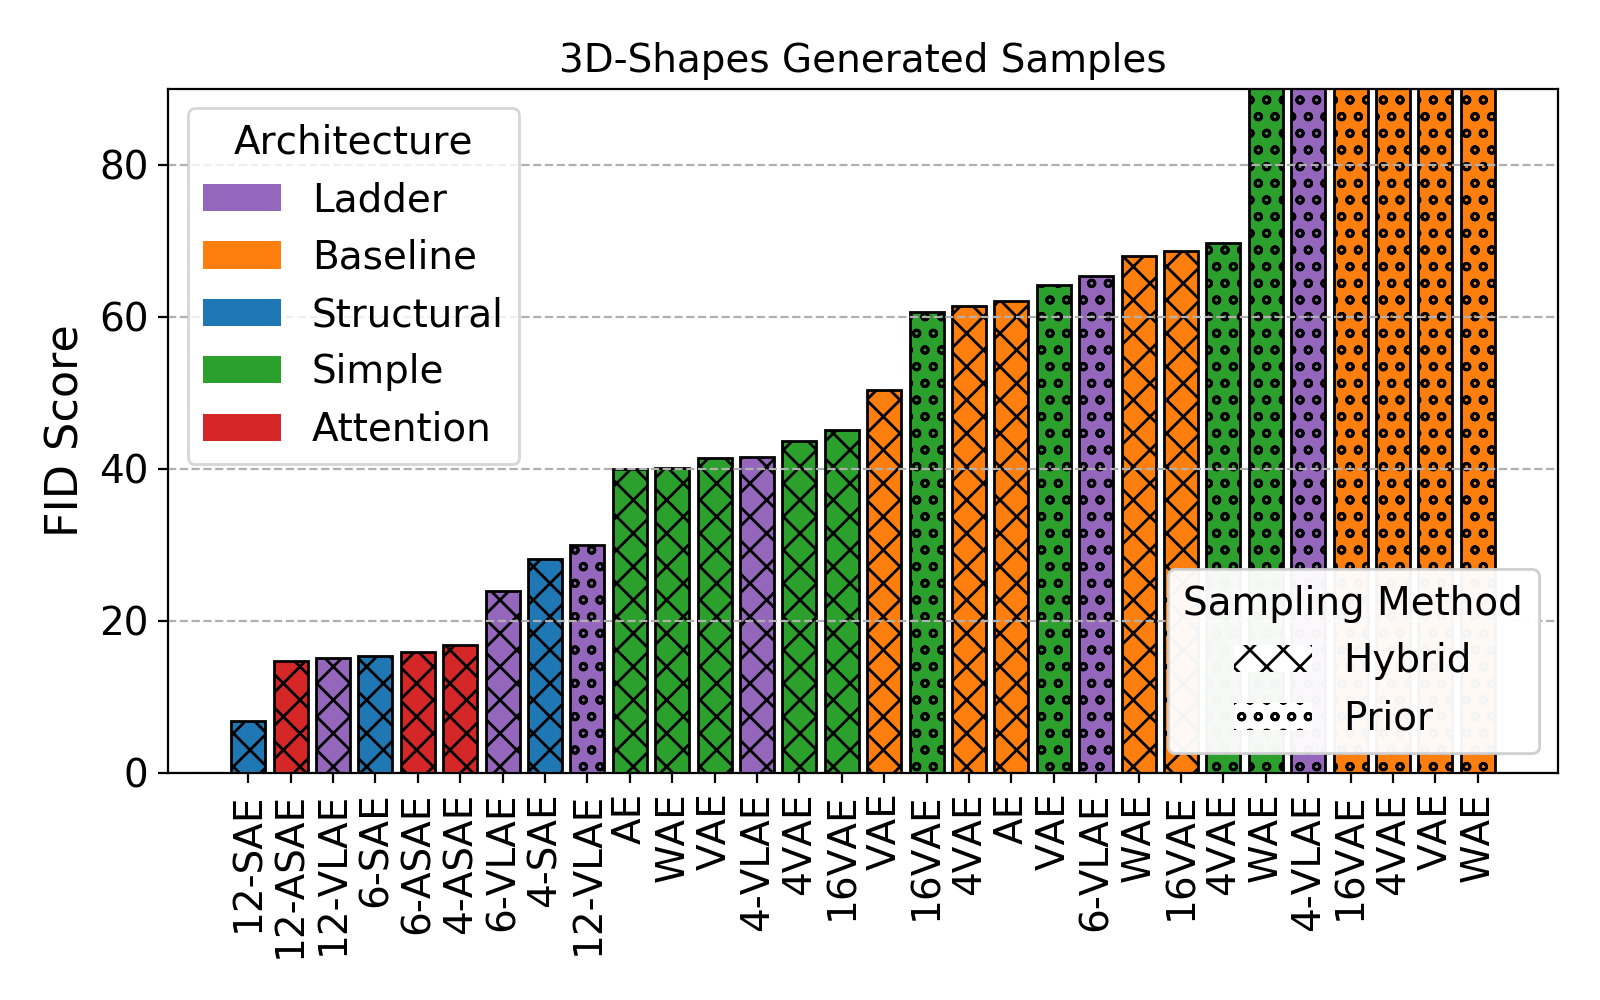

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend_elements1 = [Patch(facecolor='w', hatch='xx', label='Hybrid'), Patch(facecolor='w', hatch='oo', label='Prior')]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
plt.ylim(0,90)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
pass

In [783]:
# save_fig(f'{info.ds}_{info.results_name}_gen_perf')

3ds_final_gen_perf saved


In [27]:
list(runs.selects('name', 'arch'))

[['AE', 'Conv'],
 ['VAE', 'Conv'],
 ['4VAE', 'Conv'],
 ['16VAE', 'Conv'],
 ['WAE', 'Conv'],
 ['12-SAE', 'Branch'],
 ['6-SAE', 'Branch'],
 ['4-SAE', 'Branch'],
 ['12-ASAE', 'Attention'],
 ['6-ASAE', 'Attention'],
 ['4-ASAE', 'Attention'],
 ['12-VLAE', 'Ladder'],
 ['6-VLAE', 'Ladder'],
 ['4-VLAE', 'Ladder'],
 ['AE', 'Baseline'],
 ['VAE', 'Baseline'],
 ['4VAE', 'Baseline'],
 ['16VAE', 'Baseline'],
 ['WAE', 'Baseline']]

In [60]:
sel = runs.filter(lambda r: r.arch == 'Attention')
# sel = runs.filter(lambda r: r.name == fixed_names['12 Branch'])
# sel = runs.filter(lambda r: r.name == '16VAE' and r.arch == 'Baseline')
print(list(sel.selects('name', 'arch')))
def _label_heads(r):
    if '12' in r.name:
        r.heads = 12
    elif '6' in r.name:
        r.heads = 6
    elif '4' in r.name:
        r.heads = 4
sel.map(_label_heads)
def _settings(r):
    if 'heads' in r:
        r.tH, r.tW = {12:(12,1), 6:(6,2), 4:(4,3)}[r.heads]
        r.widths = {12:[1,8], 6:[1,3], 4:[1,2.2]}[r.heads]
    else:
        r.tH, rtW = 12,1
sel.map(_settings)
list(sel.select('name'))

[['12-ASAE', 'Attention'], ['6-ASAE', 'Attention'], ['4-ASAE', 'Attention']]


['12-ASAE', '6-ASAE', '4-ASAE']

In [61]:
# sel.map(load_data, pbar=tqdm)
sel.map(load_model, pbar=tqdm)
pass

In [62]:
run = sel[0]
model = run.model
run.name

'12-ASAE'

In [63]:
# X = run[info.results_name]['out']['original']
with torch.no_grad():
    Q = model.encode(X)
    if isinstance(Q, distrib.Normal):
        Q = Q.mean
q = Q[info.bidx]
Q.shape, q.shape

(torch.Size([128, 12]), torch.Size([12]))

In [64]:
info.n = 16
info.steps = 20
info.steps = 7
# info.steps = 5
info.ntrav = 1
info.stretch = 0.1

In [65]:
rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=info.steps,
          mnmx=(Q.min(0)[0].unsqueeze(-1)-info.stretch*rg, Q.max(0)[0].unsqueeze(-1)+info.stretch*rg)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape

torch.Size([1, 12, 7, 3, 64, 64])

In [66]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, run.tH, run.tW, S, C, H, W)
# full = full.permute(0, 3, 4, 1, 5, 2, 6).contiguous().view(B, S, C, tH * H, tW * W)
full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

full.shape

torch.Size([12, 64, 448, 3])

In [67]:
def color_ax(c):
    ax.spines['bottom'].set_color(c)
    ax.spines['top'].set_color(c) 
    ax.spines['right'].set_color(c)
    ax.spines['left'].set_color(c)
    ax.tick_params(axis='x', colors=c)
    ax.tick_params(axis='y', colors=c)
    ax.yaxis.label.set_color(c)
    ax.xaxis.label.set_color(c)
    ax.title.set_color(c)

In [68]:
cmap = cm.get_cmap('jet')

In [69]:
# highlight = [None]*12
# highlight = ['C1']*12

# highlight = [0,1,-1,2,3,-1,-1,4,-1,-1,-1,5]
# mh = max(info.highlight)
# hls = [(cmap(h/mh) if h >= 0 else 'k') for h in highlight]
# hls = [(f'C{h}' if h >= 0 else 'k') for h in info.highlight]
# len(hls), hls

<IPython.core.display.Javascript object>


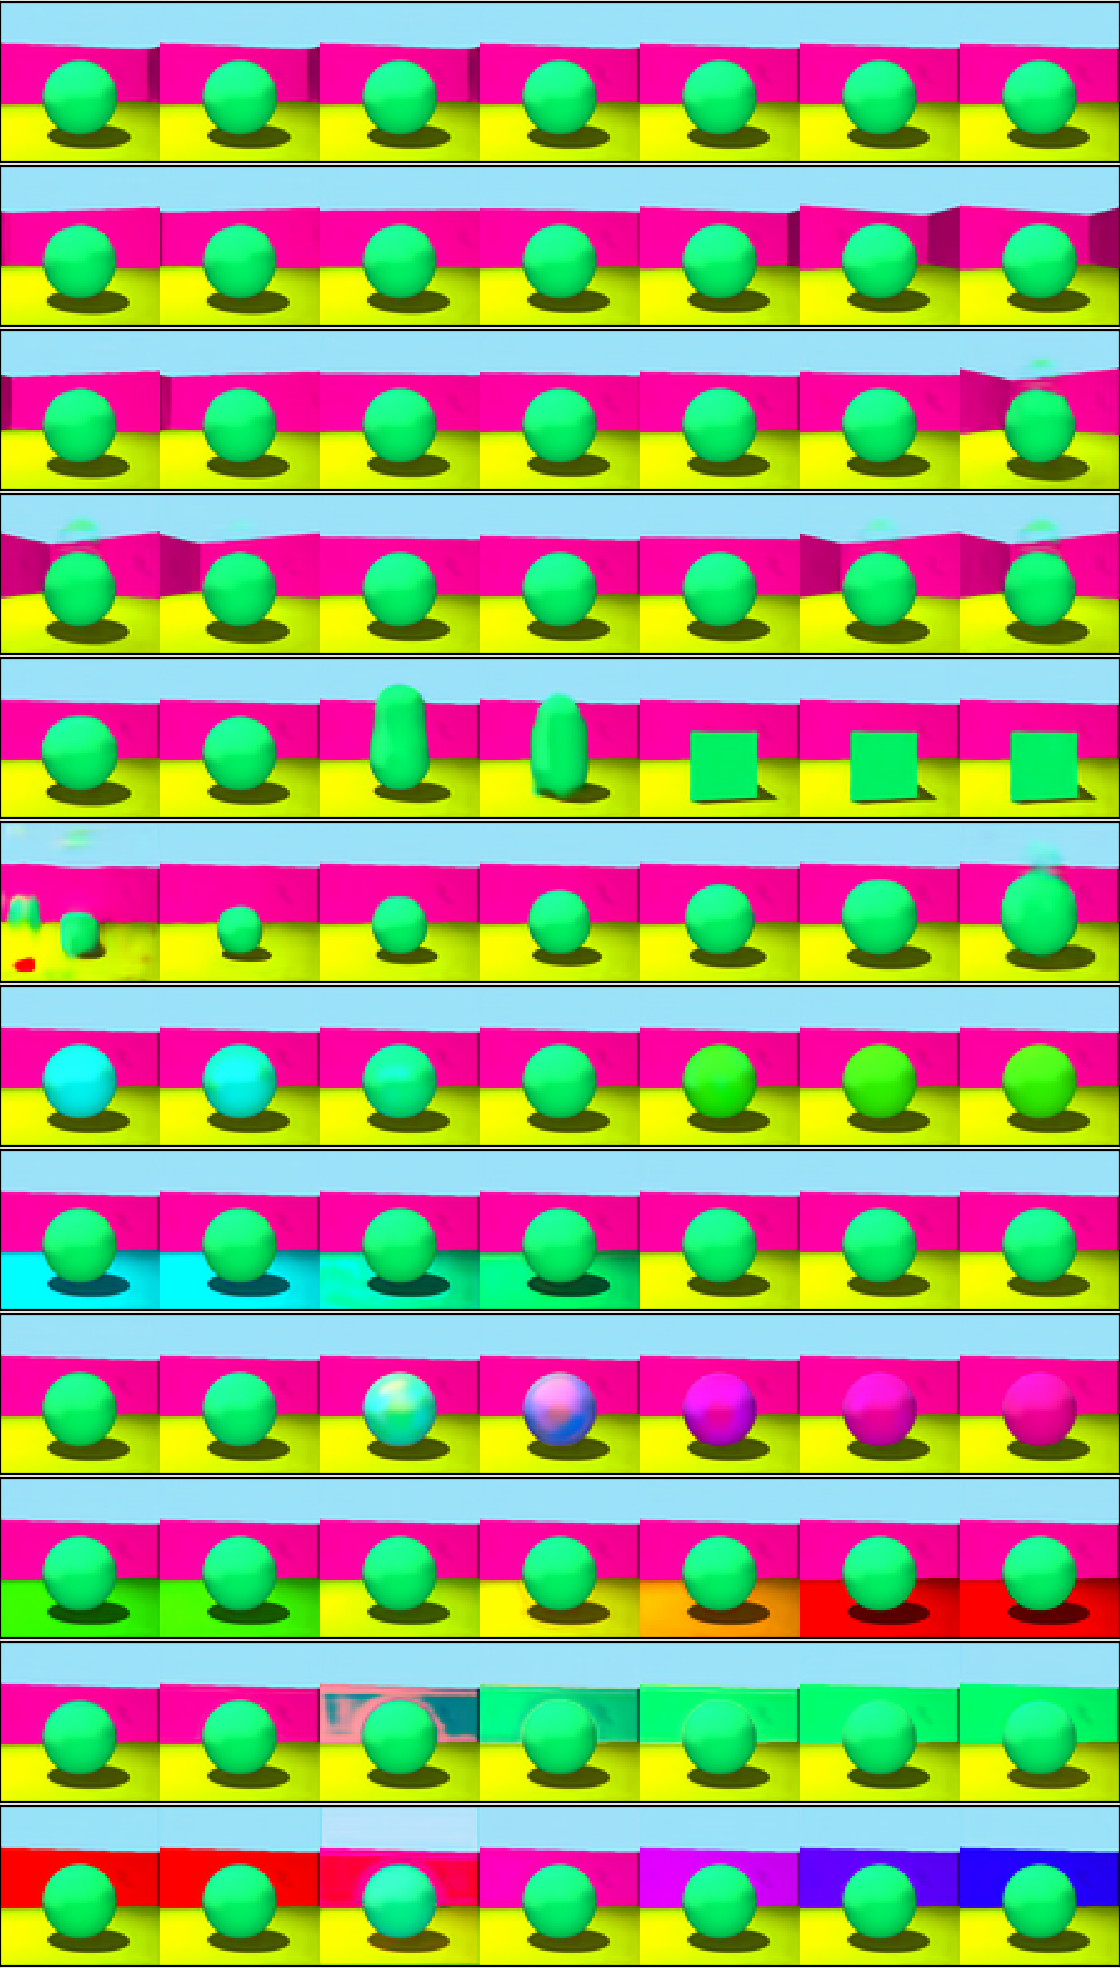

In [70]:
fig, axes = plt.subplots(run.tH,1, figsize=(info.steps*0.8,12*0.82))
for i,(ax, p) in enumerate(zip(axes,full)):
    plt.sca(ax)
    lw=3
#     ax.spines['bottom'].set_linewidth(lw)
#     ax.spines['top'].set_linewidth(lw) 
#     ax.spines['right'].set_linewidth(lw)
#     ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
border, between = 0.01, 0.02
border, between = 0.0, 0.0
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [57]:
# save_fig(f'{info.ds}_{info.results_name}_order')

3ds_final_order_bvae saved


In [71]:
# save_fig(f'{ds}_order')

In [72]:
# model#.enc.pointnet.tfms[2]

In [73]:
with torch.no_grad():
    model(X)

In [74]:
actv = model.enc.pointnet.tfms[2]._w.clone()
B, H,_,L = actv.shape
actv = actv.view(B,H,1,L)*100
actv.shape

torch.Size([128, 12, 1, 961])

In [75]:
single = actv[info.bidx]
avg = actv.mean(0)
single.shape, avg.shape

(torch.Size([12, 1, 961]), torch.Size([12, 1, 961]))

In [76]:
scolor = [1,0,0,]
acolor = [0,1,0]
scolor, acolor = torch.tensor(scolor).float(), torch.tensor(acolor).float()
scale = 2
scolor, acolor = scolor*scale, acolor*scale
scolor, acolor = scolor.view(1,3,1), acolor.view(1,3,1)
at = scolor*single + acolor*avg
print(at.max())
at = at.view(H,3,31,31).clamp(max=1)
at = at.permute(0,2,3,1).contiguous()
at.shape

tensor(184.1830)


torch.Size([12, 31, 31, 3])

<IPython.core.display.Javascript object>


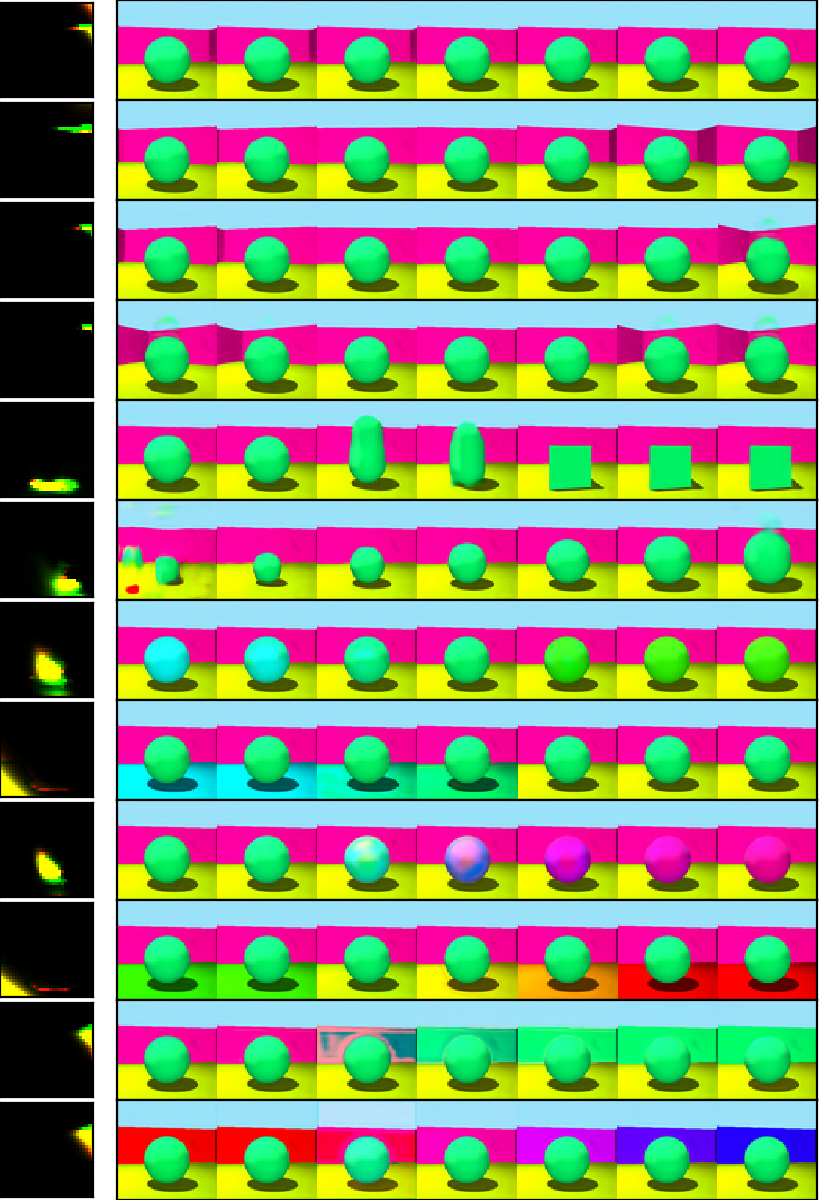

In [77]:

fig, axes = plt.subplots(run.tH,2, figsize=(4.2,6), #figsize=(5,6.8), 
                         
                         gridspec_kw={'width_ratios':run.widths})
for i,((ac,ax), p,a) in enumerate(zip(axes,full,at)):
    plt.sca(ax)
    lw=3
#     ax.spines['bottom'].set_linewidth(lw)
#     ax.spines['top'].set_linewidth(lw) 
#     ax.spines['right'].set_linewidth(lw)
#     ax.spines['left'].set_linewidth(lw)
#     if hl is not None:
#         color_ax(hl)
    plt.imshow(p.numpy())
    plt.xticks([])
    plt.yticks([])
    
    plt.sca(ac)
    plt.imshow(a.numpy())
    plt.xticks([])
    plt.yticks([])
    
border, between = 0.02, 0.05
border, between = 0.0, 0.0
plt.subplots_adjust(wspace=between, hspace=between,
                    left=border, right=1 - border, bottom=border, top=1 - border)

In [545]:
# save_fig(f'{info.ds}_attn_{run.heads}')

real_attn_4 saved


In [95]:
list(runs.selects('name', 'arch'))

[['AE', 'Conv'],
 ['VAE', 'Conv'],
 ['4VAE', 'Conv'],
 ['WAE', 'Conv'],
 ['12-SAE', 'Branch'],
 ['6-SAE', 'Branch'],
 ['4-SAE', 'Branch'],
 ['12-ASAE', 'Attention'],
 ['6-ASAE', 'Attention'],
 ['4-ASAE', 'Attention'],
 ['12-VLAE', 'Ladder'],
 ['6-VLAE', 'Ladder'],
 ['4-VLAE', 'Ladder']]

In [739]:
gen_model_names = [
#     ('AE', 'Conv'),
#     ('VAE', 'Conv'),
    ('4VAE', 'Conv'),
#     ('16VAE', 'Conv'),
#     ('WAE', 'Conv'),
    (fixed_names['12 Branch'], 'Branch'),
#     ('6 Branch', 'Branch'),
#     ('4 Branch', 'Branch'),
    (fixed_names['12 Head'], 'Attention'),
#     ('6 Head', 'Attention'),
#     ('4 Head', 'Attention'),
#     ('4 LVAE', 'Ladder'),
#     ('6 LVAE', 'Ladder'),
    (fixed_names['12 LVAE'], 'Ladder'),
#     ('AE', 'Baseline'),
#     ('VAE', 'Baseline'),
    ('4VAE', 'Baseline'),
#     ('16VAE', 'Baseline'),
#     ('WAE', 'Baseline'),
]
len(gen_model_names)

5

In [740]:
gen = runs.filter(lambda r: (r.name, r.arch) in gen_model_names)
gen.sort_by('name')
len(gen), list(gen.selects('name', 'arch'))

(5,
 [['12-ASAE', 'Attention'],
  ['12-SAE', 'Branch'],
  ['12-VLAE', 'Ladder'],
  ['4VAE', 'Conv'],
  ['4VAE', 'Baseline']])

In [747]:
# gen[1].gen = torch.load(os.path.join(os.environ['FOUNDATION_SAVE_DIR'], '3ds-ae-12b1_0052-6286534-00_200429-030431', 'adv_gen.pth.tar'))

In [742]:
# def _results(r):
#     path = os.path.join(os.environ['FOUNDATION_SAVE_DIR'], r.rname)
# #     r.results = torch.load(os.path.join(path, 'results.pth.tar'))
# #     r.out = r.results['out']
#     if 'adv_gen.pth.tar' in os.listdir(path):
#         r.gen = torch.load(os.path.join(path, 'adv_gen.pth.tar'))
# runs.map(_results, pbar=tqdm)
# pass

In [743]:
gen.map(load_model)
pass

load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1-12h1k32v32_0001-6337050-04_200508-232612\checkpoint_100000.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=point-enc)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  Creating transform (type=patch-points)
    in_shape: (3, 64, 64)
    include_coords --> coord_patches: True (in parent)
    patch_size: 4 (by default)
    stride: 2 (by default)
    dilation: 1 (by default)
    padding: 0 (by default)
  Creating pointnet (type=point-net)
    pin: 50
    latent_dim: 12 (in parent)
    n_points: 961
    modules (type=iter) with 3 elements
    Creating modules[0] (type=point-self)
      pin: 50
      pout --> key_val_dim: 64 (in parent)
      hidden --> point_tfm_hidden (type=list): 
[0]: 128
[1]: 128
[2]: 128
      nonlin: elu (in parent)
      output_nonlin: None (by default)
    Creating modules[1] (type=point-split)
    

Model on cuda
Loaded model_state from checkpoint
load successful


calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-ae-12b1-conv_0005-6337809-01_200509-120419\checkpoint_100000.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: ae
Creating encoder (type=conv)
  in_shape --> din: (3, 64, 64) (in parent)
  latent_dim: 12 (in parent)
  feature_dim: None (by default)
  nonlin: elu (in parent)
  output_nonlin: None (by default)
  residual: False (by default)
    channels (type=list): 
    [0]: 32
    [1]: 32
    [2]: 64
    [3]: 64
    [4]: 128
  kernels: 3
  strides: 2
  factors: 1
  down: max
  norm: group (in parent)
  output_norm: None (by default)
    fc_hidden (type=list): 
    [0]: 256
    [1]: 128
Creating decoder (type=branch-dec)
  latent_dim: 12 (in parent)
  out_shape --> dout: (3, 64, 64) (in parent)
  root_dim: 0
  branch_dim: 1 (in parent)
    channels (type=list): 
    [0]: 64
    [1]: 64
    [2]: 64
    [3]: 64
    [4]: 64
    [5]: 64
    [6]: 64
    [7]: 64
    [8]: 64
    [9]: 64
    [10]: 64
   

Model on cuda
Loaded model_state from checkpoint
load successful
Loaded C:\Users\anwan\Documents\workspace\trained_nets\3ds-vae-lddrev12_0042-6464006-07_200522-152910\checkpoint_100000.pth.tar
Set dataroot to: C:\Users\anwan\Documents\workspace\local_data
Model-type: vae
Creating encoder (type=ladder-enc) (mod=normal)
  latent_dim: 12 (in parent)
  min_log_std: None (by default)
  Creating layers (type=conv)
    in_shape --> din: (3, 64, 64) (in parent)
    latent_dim: None (in parent)
    feature_dim: None (by default)
    nonlin: elu (in parent)
    output_nonlin: None (by default)
    residual --> residual_core: False (in parent)
      channels (type=list): 
      [0]: 32
      [1]: 32
      [2]: 32
      [3]: 32
      [4]: 32
      [5]: 64
      [6]: 64
      [7]: 64
      [8]: 64
      [9]: 128
      [10]: 128
      [11]: 128
    kernels: 3 (in parent)
    strides: 1 (in parent)
      factors (type=list): 
      [0]: 2
      [1]: 2
      [2]: 2
      [3]: 1
      [4]: 1
      [5]:

  Creating branches[7] (type=ladder)
    style_dim --> din: 1
    features: 64
    pixelwise: False (by default)
    noise_dim: 64 (in parent)
    Creating net (type=mlp) (in parent)
      input_dim --> din: 1
      output_dim --> dout: 64
      hidden_dims --> branch_hidden (type=list): 
[0]: 64
[1]: 128
      nonlin: elu (in parent)
      output_nonlin: None (in parent)
  Creating layers[7] (type=deconv-layer)
    in_channels: 128
    out_channels: 64
    factor: 1
    size: None (by default)
    kernel_size: None (by default)
    stride: 1 (by default)
    padding: 1 (by default)
    dilation: 1 (by default)
    output_padding: 0 (by default)
    din: (128, 16, 16)
    dout: (3, 64, 64) (in parent)
    up_type: bilinear (in parent)
    norm: group (in parent)
    nonlin: elu (in parent)
    output_nonlin --> nonlin: elu (in parent)
    residual: False (by default)
      conv_kwargs (type=dict): 
  Creating branches[8] (type=ladder)
    style_dim --> din: 1
    features: 64
    pixel

In [744]:
from collections import OrderedDict

In [749]:
seqs = OrderedDict()
i= 0
N = 8

seqs['','Original', None] = X[i:i+N]

for run in gen:
    
    with torch.no_grad():
        g = run.model.generate_hybrid(N)
        seqs[run.name, 'hybrid', run.arch] = g
        
        try:
            gp = run.model.generate_prior(N)
            seqs[run.name, 'prior', run.arch] = gp
        except:
            gp = None
    
    if 'gen' in run:
        seqs[run.name, 'strctrd', run.arch] = run.gen['periodic_gen'][i:i+N].contiguous()


        
for n in seqs:
#     print(n)
    g = seqs[n].cpu()
    N,C,H,W = g.shape
    g = g.permute(2,0,3,1).contiguous().view(H,N*W,C)
    seqs[n] = g
        
seqs.keys()

odict_keys([('', 'Original', None), ('12-ASAE', 'hybrid', 'Attention'), ('12-SAE', 'hybrid', 'Branch'), ('12-SAE', 'strctrd', 'Branch'), ('12-VLAE', 'hybrid', 'Ladder'), ('12-VLAE', 'prior', 'Ladder'), ('4VAE', 'hybrid', 'Conv'), ('4VAE', 'prior', 'Conv'), ('4VAE', 'hybrid', 'Baseline'), ('4VAE', 'prior', 'Baseline')])

<IPython.core.display.Javascript object>


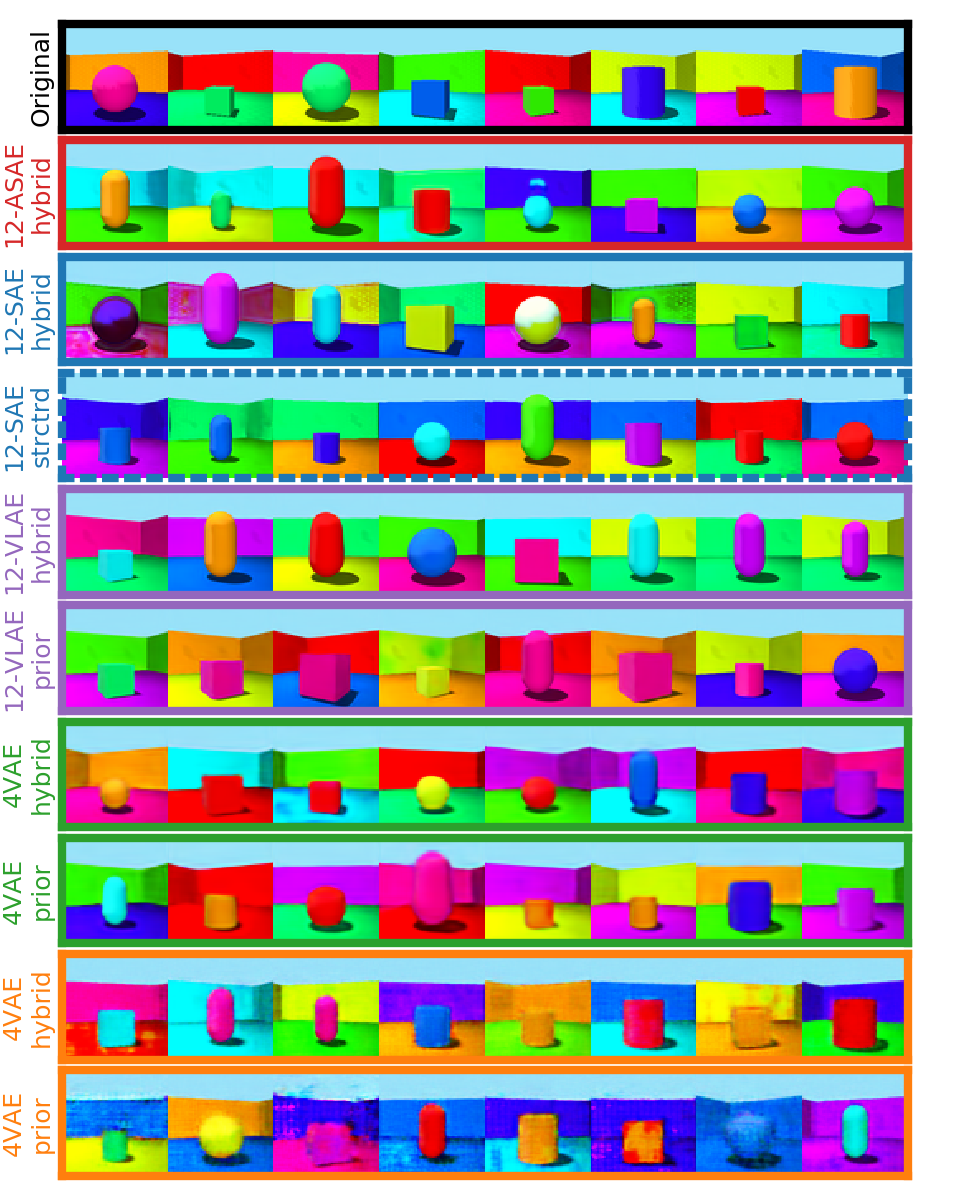

In [750]:
fig, axes = plt.subplots(len(seqs),1, figsize=(N*0.8,len(seqs)*0.80))

for i, (ax, ((n,t,a),g)) in enumerate(zip(axes, seqs.items())):
    
    plt.sca(ax)
    
    lw=4
    ax.spines['bottom'].set_linewidth(lw)
    ax.spines['top'].set_linewidth(lw) 
    ax.spines['right'].set_linewidth(lw)
    ax.spines['left'].set_linewidth(lw)
    if a in info.colors:
        color_ax(info.colors[a])
    if t == 'strctrd':
        ls = 'dotted'
#         ls = (0, (3,1,2,1))
        ax.spines['bottom'].set_linestyle(ls)
        ax.spines['top'].set_linestyle(ls) 
        ax.spines['right'].set_linestyle(ls)
        ax.spines['left'].set_linestyle(ls)
    plt.imshow(g.numpy())
    plt.ylabel(f'{n}\n{t}', fontsize=12)
#     if len(n):
#         plt.title(f'{n} ({t})')
#     else:
#         plt.title(f'{t}')
#     plt.ylabel(f'({t})')
    plt.xticks([])
    plt.yticks([])
border, between = 0.02, 0.08
border, between = 0.0, 0
plt.subplots_adjust(wspace=between, hspace=0.1,
                    left=0.01, right=1 - border, bottom=0.02, top=1 - 0.02)

In [751]:
save_fig(f'{info.ds}_gen')

3ds_gen saved
